In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import random
from contextualized.easy import ContextualizedRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters
num_stocks = 100
num_industries = 10
embedding_dim = 4
epochs = 500
lr = 0.01
reg_strength = 0.2  # weight for clustering loss

# Dummy stock-to-industry mapping (e.g. stocks 0–9 → industry 0, etc.)
stock_to_industry = torch.tensor([i // 10 for i in range(num_stocks)])

# Dummy prediction targets (e.g. simulate returns or labels)
# Just for training purposes — replace with real data
true_targets = torch.randn(num_stocks, 1)  # regression target per stock

# Dataset (each sample is one stock)
stock_ids = torch.arange(num_stocks)
industry_ids = stock_to_industry

# Model
class StockEmbedder(nn.Module):
    def __init__(self, num_stocks, num_industries, embedding_dim):
        super().__init__()
        self.stock_embedding = nn.Embedding(num_stocks, embedding_dim)
        self.industry_embedding = nn.Embedding(num_industries, embedding_dim)
        self.predictor = nn.Linear(embedding_dim, 1)  # Dummy prediction head
    
    def forward(self, stock_ids, industry_ids):
        stock_vecs = self.stock_embedding(stock_ids)         # [N, 4]
        industry_vecs = self.industry_embedding(industry_ids)  # [N, 4]
        preds = self.predictor(stock_vecs)  # dummy prediction task
        return stock_vecs, industry_vecs, preds

# Instantiate
embedder = StockEmbedder(num_stocks, num_industries, embedding_dim)
optimizer = optim.Adam(embedder.parameters(), lr=lr)
mse = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    embedder.train()
    optimizer.zero_grad()

    stock_vecs, industry_vecs, preds = embedder(stock_ids, industry_ids)
    
    # Dummy regression loss
    prediction_loss = mse(preds, true_targets)

    # Clustering loss: encourage each stock embedding to stay close to its industry
    clustering_loss = mse(stock_vecs, industry_vecs)

    # Total loss
    loss = prediction_loss + reg_strength * clustering_loss
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {loss.item():.4f}")


Epoch 50/500, Total Loss: 0.7406
Epoch 100/500, Total Loss: 0.2244
Epoch 150/500, Total Loss: 0.1015
Epoch 200/500, Total Loss: 0.0659
Epoch 250/500, Total Loss: 0.0461
Epoch 300/500, Total Loss: 0.0338
Epoch 350/500, Total Loss: 0.0259
Epoch 400/500, Total Loss: 0.0207
Epoch 450/500, Total Loss: 0.0171
Epoch 500/500, Total Loss: 0.0146


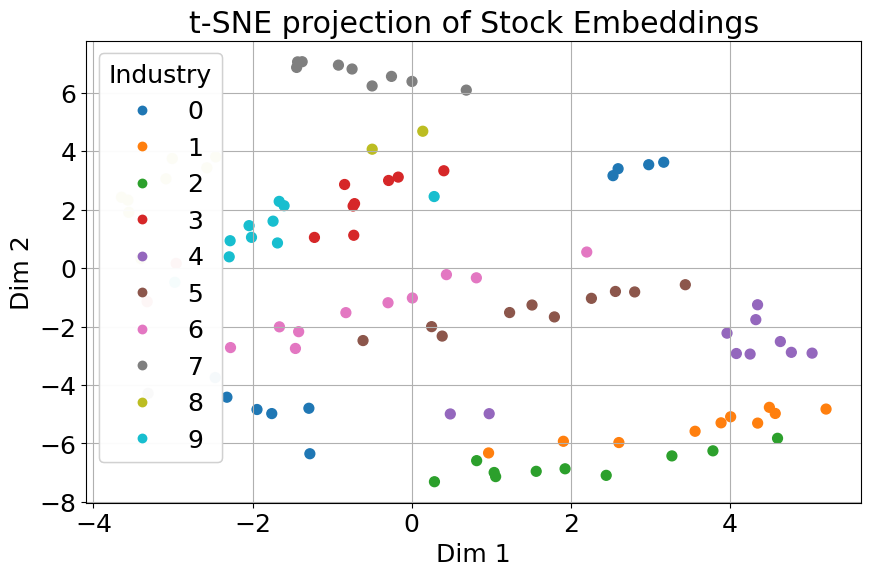

In [97]:
# ---- Visualize embeddings using t-SNE ----
embedder.eval()
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # [100, 4]
    industry_colors = stock_to_industry.numpy()

    # Reduce to 2D using t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    stock_2d = tsne.fit_transform(stock_embeddings)

    # Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(stock_2d[:, 0], stock_2d[:, 1], c=industry_colors, cmap='tab10', s=50)
    plt.title("t-SNE projection of Stock Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    legend1 = plt.legend(*scatter.legend_elements(), title="Industry")
    plt.gca().add_artist(legend1)
    plt.grid(True)
    plt.show()

In [131]:
import pandas as pd
import numpy as np
import torch

# Get trained stock embeddings from your model
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # shape: [100, embedding_dim]

# Simulation parameters
n_stocks = 100
n_quarters = 20
embedding_dim = 4  # must match your model

# Define stock IDs and quarters
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_quarters))  # Q0, Q1, ..., Q19

# Assign each stock to an industry (10 industries)
industries = {stock: i // 10 for i, stock in enumerate(stocks)}  # Stock_0–9 → 0, Stock_10–19 → 1, ..., Stock_90–99 → 9

# Create full panel (stock x quarter)
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Add industry column
df["industry"] = df["stock_id"].map(industries)

# Simulate predictors
df["div_yield_change"] = np.random.normal(0, 0.1, len(df))
df["ptb_change"] = np.random.normal(0, 0.1, len(df))

# Simulate Homogenous Predictor Slope (Slopes from predictors which do not depend on context)
hom_slope = -0.2

# Simulate Homogenous context predictors (Biases directly from context which do not depend on predictors)
stock_effects = {
    f"Stock_{i}": 0.3*np.sum(np.sin(stock_embeddings[i]))
    for i in range(len(stock_embeddings))
}
stock_effects = {stock: np.random.normal(0, 0.1) for stock in stocks}
stock_effects = {stock: 0 for stock in stocks}

time_effects = {q: 0.3*np.sin(q) for q in quarters}
time_effects = {q: 0 for q in quarters}

# Simulate Heterogenous Predictor (Slopes from predictors which are modulated by context)
stock_slopes = {
    stock: 0.6 + 0.5 * industries[stock] + 0.002 * (i % 10)  # small variation within industry
    for i, stock in enumerate(stocks)
}
stock_slopes = {
    f"Stock_{i}": np.sum(stock_embeddings[i])
    for i in range(len(stock_embeddings))
}
stock_slopes = {stock: 0.65 for stock in stocks}
stock_slopes = {stock: 5 + 3 * np.random.rand() for stock in stocks}


# Add explicit stock and time effect columns
df["stock_slope"] = df["stock_id"].map(stock_slopes)
df["stock_bias"] = df["stock_id"].map(stock_effects)
df["time_bias"] = df["quarter"].map(time_effects)


# Simulate returns using all components
df["return"] = (
    df["stock_bias"]
    + df["time_bias"]
    + hom_slope * df["ptb_change"]
    + df["stock_slope"] * df["div_yield_change"]
    #+ np.random.normal(0, 0.05, len(df))  # Optional noise
)

df.tail(25)


,stock_id,quarter,industry,div_yield_change,ptb_change,stock_slope,stock_bias,time_bias,return
1975,Stock_98,15,9,-0.083215,0.041298,7.769626,0,0,-0.654809
1976,Stock_98,16,9,0.020786,0.003207,7.769626,0,0,0.160858
1977,Stock_98,17,9,0.068457,0.004810,7.769626,0,0,0.530924
1978,Stock_98,18,9,0.008752,0.174121,7.769626,0,0,0.033172
1979,Stock_98,19,9,-0.042413,-0.167228,7.769626,0,0,-0.296090
1980,Stock_99,0,9,-0.028710,0.231782,7.590612,0,0,-0.264286
1981,Stock_99,1,9,0.065217,0.117827,7.590612,0,0,0.471471
1982,Stock_99,2,9,-0.110018,-0.032579,7.590612,0,0,-0.828585
1983,Stock_99,3,9,-0.081646,0.039123,7.590612,0,0,-0.627566
1984,Stock_99,4,9,-0.160690,-0.068285,7.590612,0,0,-1.206079


In [135]:
df["stock_slope"].mean()

6.615694692658076

In [136]:
# Convert to panel format
df = df.set_index(["stock_id", "quarter"])

Pooled_OLS_model = PanelOLS(
    dependent=df["return"],
    exog=df[["div_yield_change", "ptb_change"]],
    entity_effects=False,
    time_effects=False
)
results_OLS = Pooled_OLS_model.fit(cov_type="clustered", cluster_entity=True)

# Run the fixed effects model
fixed_effects_model = PanelOLS(
    dependent=df["return"],
    exog=df[["div_yield_change", "ptb_change"]],
    entity_effects=True,
    time_effects=True
)
results_fixed_effects = fixed_effects_model.fit(cov_type="clustered", cluster_entity=True)

# Print summary
print(results_OLS.summary)
print(results_fixed_effects.summary)

KeyError: "None of ['stock_id', 'quarter'] are in the columns"

In [137]:
# Predictions
df["OLS predicted_return"] = results_OLS.predict().fitted_values
df["Fixed Effects predicted_return"] = results_fixed_effects.predict().fitted_values
df_reset = df.reset_index()

df.tail(25)

industry  div_yield_change  ptb_change  stock_slope  \
stock_id quarter                                                        
Stock_98 15              9         -0.083215    0.041298     7.769626   
         16              9          0.020786    0.003207     7.769626   
         17              9          0.068457    0.004810     7.769626   
         18              9          0.008752    0.174121     7.769626   
         19              9         -0.042413   -0.167228     7.769626   
Stock_99 0               9         -0.028710    0.231782     7.590612   
         1               9          0.065217    0.117827     7.590612   
         2               9         -0.110018   -0.032579     7.590612   
         3               9         -0.081646    0.039123     7.590612   
         4               9         -0.160690   -0.068285     7.590612   
         5               9          0.003400    0.031923     7.590612   
         6               9          0.086189    0.214984     7.590612   
         7               9          0.133148   -0.064629     7.590612   
         8               9          0.154867   -0.023201     7.590612   
         9               9         -0.069047   -0.075677     7.590612   
         10              9          0.025003   -0.059611     7.590612   
         11              9         -0.040231   -0.040269     7.590612   
         12              9          0.164764   -0.109489     7.590612   
         13              9          0.130345   -0.026361     7.590612   
         14              9          0.016807    0.005423     7.590612   
         15              9         -0.061936   -0.040315     7.590612   
         16              9         -0.344804   -0.229910     7.590612   
         17              9         -0.143360   -0.015432     7.590612   
         18              9         -0.185229   -0.004727     7.590612   
         19              9         -0.144623    0.189754     7.590612   

                  stock_bias  time_bias    return  OLS predicted_return  \
stock_id quarter                                                          
Stock_98 15                0          0 -0.654809             -0.563186   
         16                0          0  0.160858              0.137946   
         17                0          0  0.530924              0.455477   
         18                0          0  0.033172              0.023203   
         19                0          0 -0.296090             -0.249039   
Stock_99 0                 0          0 -0.264286             -0.238221   
         1                 0          0  0.471471              0.411058   
         2                 0          0 -0.828585             -0.726983   
         3                 0          0 -0.627566             -0.552283   
         4                 0          0 -1.206079             -1.057641   
         5                 0          0  0.019422              0.016225   
         6                 0          0  0.611229              0.531278   
         7                 0          0  1.023602              0.900833   
         8                 0          0  1.180172              1.037280   
         9                 0          0 -0.508977             -0.445107   
         10                0          0  0.201711              0.178746   
         11                0          0 -0.297326             -0.260119   
         12                0          0  1.272560              1.120694   
         13                0          0  0.994668              0.874414   
         14                0          0  0.126492              0.110969   
         15                0          0 -0.462066             -0.404827   
         16                0          0 -2.571294             -2.252624   
         17                0          0 -1.085104             -0.952760   
         18                0          0 -1.405058             -1.234090   
         19                0          0 -1.135730             -1.002604   

                  Fi

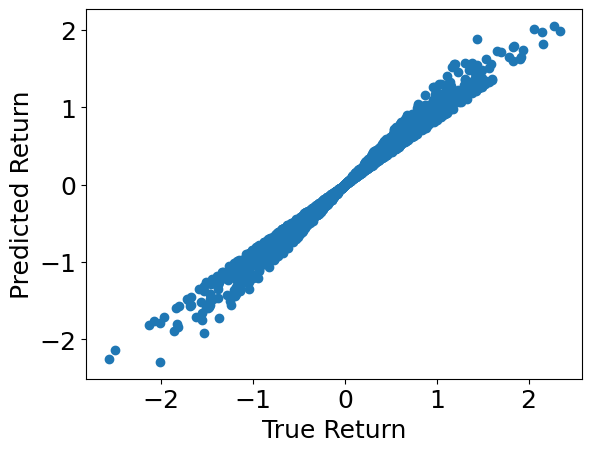

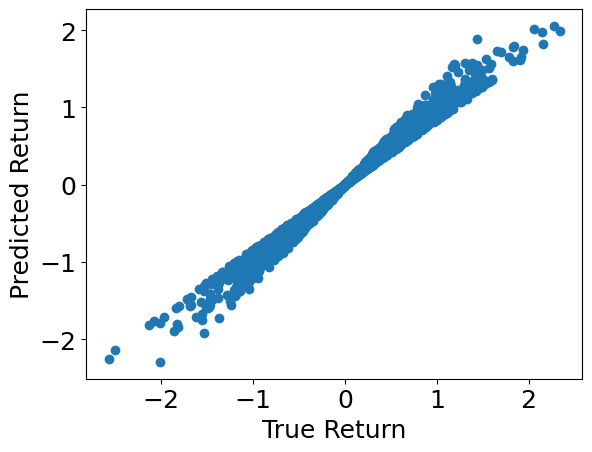

Mean-squared Error: 0.0067965213753312555
Correlation: 0.984725582884299


In [138]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(df['return'], df['OLS predicted_return'])
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.show()

plt.scatter(df['return'], df['Fixed Effects predicted_return'])
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.show()

from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(df["return"], df["Fixed Effects predicted_return"])}')
print(f'Correlation: {r2_score(df["return"], df["Fixed Effects predicted_return"])}')

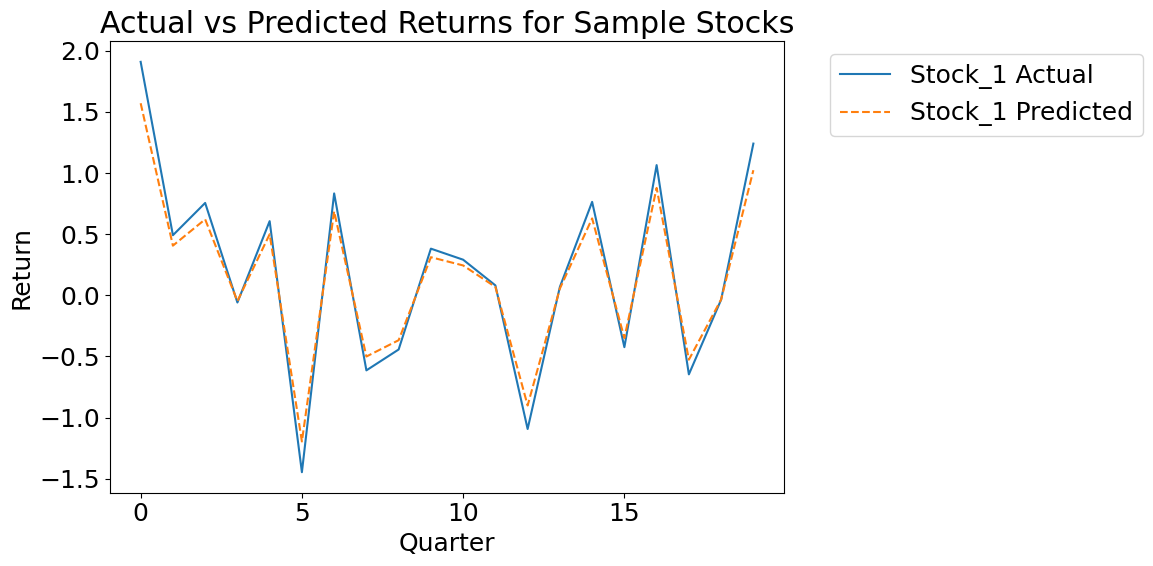

In [128]:
# Plot for first 5 stocks
fig, ax = plt.subplots(figsize=(12, 6))
sample_stocks = df_reset["stock_id"].unique()[1:2]

for stock in sample_stocks:
    stock_data = df_reset[df_reset["stock_id"] == stock]
    ax.plot(stock_data["quarter"], stock_data["return"], label=f"{stock} Actual", linestyle='-')
    ax.plot(stock_data["quarter"], stock_data['Fixed Effects predicted_return'], label=f"{stock} Predicted", linestyle='--')

ax.set_title("Actual vs Predicted Returns for Sample Stocks")
ax.set_xlabel("Quarter")
ax.set_ylabel("Return")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
df = df.reset_index()

# ----- Get stock embeddings from the trained model -----
embedder.eval()
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # shape: [100, 4]

# Create a DataFrame mapping stock name to its embedding
embedding_df = pd.DataFrame(stock_embeddings, columns=[f"embed_dim_{i}" for i in range(embedding_dim)])
embedding_df["stock_id"] = [f"Stock_{i}" for i in range(n_stocks)]

# ----- Merge embeddings into the panel -----
df = df.merge(embedding_df, on="stock_id", how="left")

df.head()

,stock_id,quarter,industry,div_yield_change,ptb_change,stock_slope,stock_bias,time_bias,return,predicted_return,embed_dim_0,embed_dim_1,embed_dim_2,embed_dim_3
0,Stock_0,0,0,0.049671,-0.067518,0.65,0,0.000000,0.045790,0.045771,0.028365,0.626124,-0.003805,-0.73686
1,Stock_0,1,0,-0.013826,-0.014452,0.65,0,0.252441,0.246344,-0.007518,0.028365,0.626124,-0.003805,-0.73686
2,Stock_0,2,0,0.064769,-0.079242,0.65,0,0.272789,0.330737,0.058301,0.028365,0.626124,-0.003805,-0.73686
3,Stock_0,3,0,0.152303,-0.030796,0.65,0,0.042336,0.147492,0.112660,0.028365,0.626124,-0.003805,-0.73686
4,Stock_0,4,0,-0.023415,-0.189361,0.65,0,-0.227041,-0.204388,0.013171,0.028365,0.626124,-0.003805,-0.73686


In [ ]:
# Use stock_id and quarter as context
context_df = df[["embed_dim_0", "embed_dim_1", "embed_dim_2", "embed_dim_3", "quarter"]].copy()
context_df["quarter"] = context_df["quarter"].astype(int)

# Predictors
X = df[["div_yield_change", "ptb_change"]].values
Y = df["return"].values.reshape(-1, 1)
C = context_df.values  # context = (stock_id, quarter)

In [ ]:
# -------------------------------
# 3. Split and normalize
# -------------------------------

C_train, C_test, X_train, X_test, Y_train, Y_test = train_test_split(C, X, Y, test_size=0.2, random_state=42)

def normalize(train, test):
    mean = train.mean(axis=0)
    std = train.std(axis=0)
    return (train - mean) / std, (test - mean) / std

In [ ]:
model = ContextualizedRegressor()
model.fit(C, X, Y,
          encoder_type="mlp",
          max_epochs=10,
          learning_rate=1e-2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/lightning_logs/boot_0_checkpoints exists and is not empty.

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | metamodel | NaiveMetamodel | 1.5 K  | train
-----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck.

In [ ]:
contextualized_coeffs, contextualized_offsets = model.predict_params(C)
Y_pred = model.predict(C, X)

from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(Y, Y_pred)}')
print(f'Correlation: {r2_score(Y, Y_pred)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Mean-squared Error: 0.038789002414745824
Correlation: 0.18700077757323796


In [ ]:
contextualized_coeffs, contextualized_offsets

(array([[[ 0.72590691,  0.03253784]],
 
        [[ 0.62173057, -0.10757285]],
 
        [[ 0.62166619, -0.10767265]],
 
        ...,
 
        [[ 0.72590691,  0.03253784]],
 
        [[ 0.72590691,  0.03253784]],
 
        [[ 0.72590691,  0.03253784]]]),
 array([[0.03450246],
        [0.27834868],
        [0.27851519],
        ...,
        [0.03450246],
        [0.03450246],
        [0.03450246]]))

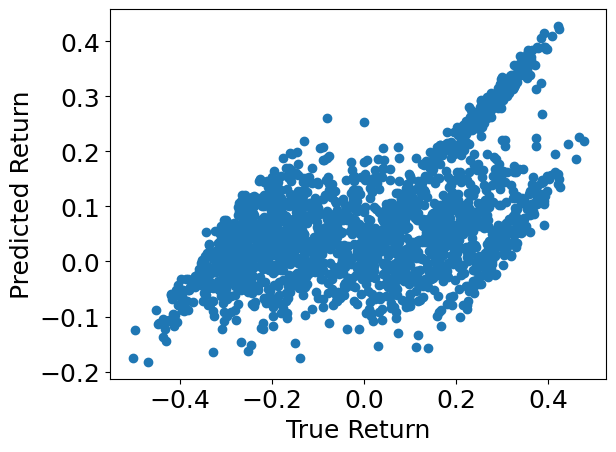

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(Y, Y_pred)
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.show()